# **Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import ParameterGrid
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier

# **Preparing Data**

In [ ]:
columns = ['datetime','discharge_patapsco (catonsville)',
           'gage_height_patapsco (catonsville)', 'discharge_patapsco (elkridge)',
           'gage_height_patapsco (elkridge)', 'HourlyAltimeterSetting',
           'HourlyDryBulbTemperature',
           'HourlyPrecipitation', 'HourlyRelativeHumidity','HourlyStationPressure', 
           'y']

df = pd.read_csv('test_train_2events.csv')
df = df[columns]
df['datetime'] = pd.to_datetime(df['datetime'])

In [ ]:
# handling the cells in df['HourlyPrecipitation'] labeled as 'T'
# if the cell is 'T', replace 'T' with value of previous cell

#returns a list of indices for cells == 'T' in df['HourlyPrecipitation']
index = df.loc[df['HourlyPrecipitation'] == 'T', :].index 

for i in index:
    if df['HourlyPrecipitation'][i] == 'T': 
    #appending cells == 'T' with values of their previous cells
        df['HourlyPrecipitation'][i] = df['HourlyPrecipitation'][i-1] 

<ipython-input-4-715884683dd5>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HourlyPrecipitation'][i] = df['HourlyPrecipitation'][i-1]


In [ ]:
# changing labels in df['y']
# 0 is now 'no flood'. 1 is 'flood'
# this step is needed for the encoding later

for i in df.index:
    if df['y'][i] == 0:
        df['y'][i] = 'no flood'
    if df['y'][i] == 1:
        df['y'][i] = 'flood'

<ipython-input-5-ac79e0484e16>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'][i] = 'no flood'
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-5-ac79e0484e16>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'][i] = 'flood'


In [ ]:
df['HourlyPrecipitation'] = df['HourlyPrecipitation'].astype('float64') 
# prcp data was in 'object' format due to the 'T' mislabeling

In [ ]:
# splitting training and testing data

train = df[df['datetime'].dt.year == 2018]
train = train.drop(['datetime'],axis=1)

test = df[df['datetime'].dt.year == 2016]
test = test.drop(['datetime'],axis=1)

In [ ]:
# encoding the data

def encode(train, test):
    label_encoder_train = LabelEncoder().fit(train['y'])
    labels_train = label_encoder_train.transform(train['y'])

    label_encoder_test = LabelEncoder().fit(test['y'])
    labels_test = label_encoder_test.transform(test['y'])

    classes = list(label_encoder_test.classes_)

    train = train.drop(['y'], axis=1)
    test = test.drop(['y'], axis=1)

    return train, labels_train, test, labels_test , classes

In [ ]:
# for training and testing

train, labels_train, test, labels_test , classes = encode(train, test)

In [ ]:
# standardize train features
scaler = StandardScaler().fit(train.values)
scaled_train = scaler.transform(train.values)

In [ ]:
# split train data into train and validation
sss = StratifiedShuffleSplit(test_size=0.1, random_state=23)
for train_index, valid_index in sss.split(scaled_train, labels_train):
    X_train, X_valid = scaled_train[train_index], scaled_train[valid_index]
    y_train, y_valid = labels_train[train_index], labels_train[valid_index]

In [ ]:
# standardize test features
scaler_test = StandardScaler().fit(test.values)
scaled_test = scaler_test.transform(test.values)

In [ ]:
# for confusion matrix and scoring

X_test = scaled_test
y_test0 = labels_test

In [ ]:
# for cross validation usage

x_cross_val = pd.concat([test,train],axis=0) # test is 2016 event, train is 2018
scaler_cross_val = StandardScaler().fit(x_cross_val.values)
x = scaler.transform(x_cross_val.values)

y = np.hstack((labels_test,labels_train))

In [ ]:
nb_features = 3 # number of features per features type (discharge, temp., pressure)   
nb_class = len(classes)

# reshape train data
X_train_r = np.zeros((len(X_train), nb_features, 3))
X_train_r[:, :, 0] = X_train[:, :nb_features]
X_train_r[:, :, 1] = X_train[:, nb_features:6]
X_train_r[:, :, 2] = X_train[:, 6:]

# reshape validation data
X_valid_r = np.zeros((len(X_valid), nb_features, 3))
X_valid_r[:, :, 0] = X_valid[:, :nb_features]
X_valid_r[:, :, 1] = X_valid[:, nb_features:6]
X_valid_r[:, :, 2] = X_valid[:, 6:]

# reshape test data
X_test_r = np.zeros((len(X_test), nb_features, 3))
X_test_r[:, :, 0] = X_test[:, :nb_features]
X_test_r[:, :, 1] = X_test[:, nb_features:6]
X_test_r[:, :, 2] = X_test[:, 6:]

# reshape cross validation data
X_r = np.zeros((len(x), nb_features, 3))
X_r[:, :, 0] = x[:, :nb_features]
X_r[:, :, 1] = x[:, nb_features:6]
X_r[:, :, 2] = x[:, 6:]

In [ ]:
y_train = np_utils.to_categorical(y_train, nb_class)
y_valid = np_utils.to_categorical(y_valid, nb_class)

# **Building and Training the Model**

In [ ]:
# Keras model with one Convolution1D layer
# unfortunately more number of covnolutional layers, filters and filters lenght 
# don't give better accuracy

def create_model():
    model = Sequential()
    model.add(Convolution1D(filters = 3, kernel_size = 1, 
                          input_shape=(nb_features, 3)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(nb_class))
    model.add(Activation('softmax'))
    sgd = SGD(lr=0.01, nesterov=True, decay=1e-6, momentum=0.9)
    model.compile(loss='categorical_crossentropy',
                optimizer=sgd,metrics=['accuracy'])
  
    return model


model = KerasClassifier(build_fn= create_model,epochs=100,
                        shuffle=False,verbose=2)

In [ ]:
model.fit(X_train_r, y_train,validation_data=(X_valid_r, y_valid))

/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
44/44 - 16s - loss: 0.4642 - accuracy: 0.8374 - val_loss: 0.3315 - val_accuracy: 0.9156
Epoch 2/100
44/44 - 1s - loss: 0.3415 - accuracy: 0.8902 - val_loss: 0.2872 - val_accuracy: 0.9156
Epoch 3/100
44/44 - 1s - loss: 0.3257 - accuracy: 0.8931 - val_loss: 0.2625 - val_accuracy: 0.9156
Epoch 4/100
44/44 - 1s - loss: 0.3084 - accuracy: 0.8988 - val_loss: 0.2435 - val_accuracy: 0.9286
Epoch 5/100
44/44 - 1s - loss: 0.3025 - accuracy: 0.9010 - val_loss: 0.2313 - val_accuracy: 0.9351
Epoch 6/100
44/44 - 1s - loss: 0.2751 - accuracy: 0.9111 - val_loss: 0.2054 - val_accuracy: 0.9416
Epoch 7/100
44/44 - 1s - loss: 0.2611 - accuracy: 0.9140 - val_loss: 0.1942 - val_accuracy: 0.9416
Epoch 8/100
44/44 - 1s - loss: 0.2519 - accuracy: 0.9220 - val_loss: 0.1830 - val_accuracy: 0.9416
Epoch 9/100
44/44 - 1s - loss: 0.2484 - accuracy: 0.9191 - val_loss: 0.1819 - val_accuracy: 0.9481
Epoch 10/100
44/44 - 1s - loss: 0.2466 - accuracy: 0.9234 - val_loss: 0.1770 - val_accuracy: 0.9416
Epoch 11

# **Evaluation**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
y_pred = model.predict(X_test_r)

24/24 - 0s


Text(0.5, 1.0, 'Confusion Matrix')

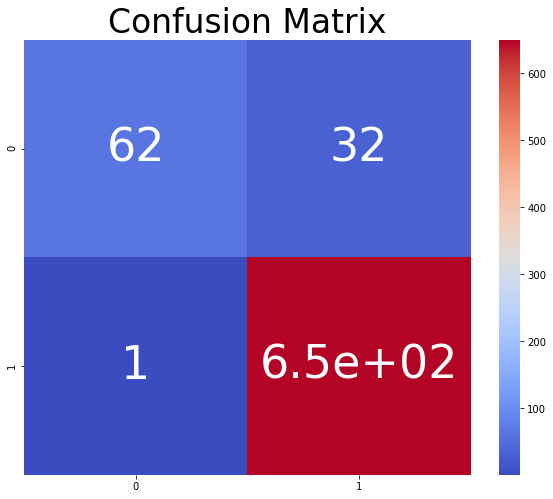

In [ ]:
#plotting the confusion matrix

cm = confusion_matrix(labels_test,y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm,cmap='coolwarm',annot=True,annot_kws={'size':46})
plt.title('Confusion Matrix',fontsize=33)

In [ ]:
#scoring the model
score = model.score(X_test_r,y_test0)
print("Test accuracy = %f%%" % (score*100))

24/24 - 0s - loss: 0.4289 - accuracy: 0.9557
Test accuracy = 95.570469%


In [ ]:
accuracy_scores = cross_val_score(model, X_r, y,cv= 5,
                                  scoring = 'accuracy')

/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
58/58 - 2s - loss: 0.5933 - accuracy: 0.7579
Epoch 2/100
58/58 - 2s - loss: 0.3665 - accuracy: 0.8768
Epoch 3/100
58/58 - 2s - loss: 0.3510 - accuracy: 0.8855
Epoch 4/100
58/58 - 1s - loss: 0.3093 - accuracy: 0.8992
Epoch 5/100
58/58 - 2s - loss: 0.3022 - accuracy: 0.8992
Epoch 6/100
58/58 - 1s - loss: 0.2834 - accuracy: 0.9042
Epoch 7/100
58/58 - 1s - loss: 0.3044 - accuracy: 0.8965
Epoch 8/100
58/58 - 1s - loss: 0.2937 - accuracy: 0.9003
Epoch 9/100
58/58 - 1s - loss: 0.2880 - accuracy: 0.9003
Epoch 10/100
58/58 - 1s - loss: 0.2824 - accuracy: 0.9036
Epoch 11/100
58/58 - 1s - loss: 0.2793 - accuracy: 0.9080
Epoch 12/100
58/58 - 1s - loss: 0.2809 - accuracy: 0.9009
Epoch 13/100
58/58 - 1s - loss: 0.2790 - accuracy: 0.9025
Epoch 14/100
58/58 - 1s - loss: 0.2568 - accuracy: 0.9113
Epoch 15/100
58/58 - 1s - loss: 0.2777 - accuracy: 0.9036
Epoch 16/100
58/58 - 1s - loss: 0.2697 - accuracy: 0.9085
Epoch 17/100
58/58 - 1s - loss: 0.2514 - accuracy: 0.9096
Epoch 18/100
58/58 - 1s

In [ ]:
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores, np.mean(accuracy_scores), np.std(accuracy_scores)))

accuracy scores = [0.99781182 0.88402626 0.90153173 0.98464912 0.88377193], mean = 0.9303581711390073, stdev = 0.050289938328839774


# **CNN vs. Synthetic Data**

In [ ]:
df_gan = pd.read_csv("gan_data3.csv")
df_gan = df_gan.drop(['Unnamed: 0','HourlyDewPointTemperature','HourlyVisibility'],axis=1)

In [ ]:
x_gan = df_gan.drop(['y'],axis=1)

# standardize train features
scaler_gan = StandardScaler().fit(x_gan.values)
scaled_gan= scaler_gan.transform(x_gan.values)

In [ ]:
# reshape gan data
X_gan_r = np.zeros((len(scaled_gan), nb_features, 3))
X_gan_r[:, :, 0] = scaled_gan[:, :nb_features]
X_gan_r[:, :, 1] = scaled_gan[:, nb_features:6]
X_gan_r[:, :, 2] = scaled_gan[:, 6:]

In [ ]:
y_gan = df_gan['y'].astype('int64').values

In [ ]:
y_pred_gan = model.predict(X_gan_r)

/opt/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


32/32 - 0s


Text(0.5, 1.0, 'Confusion Matrix')

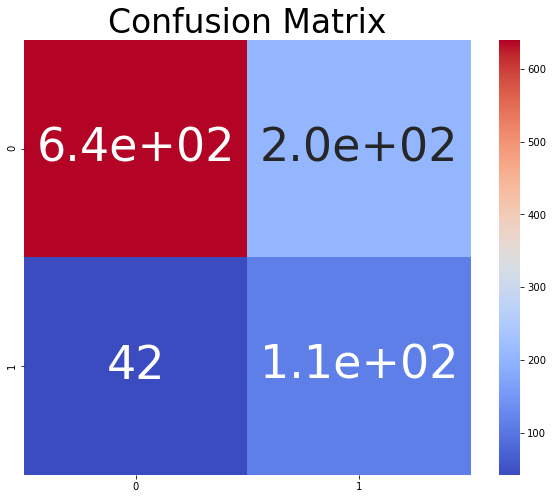

In [ ]:
#plotting the confusion matrix for the gan data output

cm = confusion_matrix(y_gan,y_pred_gan)

plt.figure(figsize=(10,8))
sns.heatmap(cm,cmap='coolwarm',annot=True,annot_kws={'size':46})
plt.title('Confusion Matrix',fontsize=33)

In [ ]:
#scoring the model with GAN data
score_gan = model.score(X_gan_r,y_gan)
print("Test accuracy = %f%%" % (score_gan*100))

32/32 - 0s - loss: 2.5244 - accuracy: 0.7530
Test accuracy = 75.300002%
